# automated style comparison of a large number of images 
**remeber to update all the paths, this is meant to work on my machine**

In [2]:
#download some sample images
!git clone https://github.com/fmerizzi/inpainting_dataset

fatal: destination path 'inpainting_dataset' already exists and is not an empty directory.


In [3]:
#select the image 
style_source = "/home/fmerizzi/Documents/letter_style/new_letters/1/bw_512_blur/blur_re_bw_v1.png"


# Select the layers on which compute the gram matrix 
style_layers_default = [ 'conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5','conv_6',
                        'conv_7', 'conv_8', 'conv_9', 'conv_10','conv_11', 'conv_12', 
                        'conv_13', 'conv_14', 'conv_15','conv_16']

## Load the image

In [4]:
%matplotlib inline

In [24]:
from __future__ import print_function

import 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# desired size of the output image
imsize = 512 #if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(style_source)

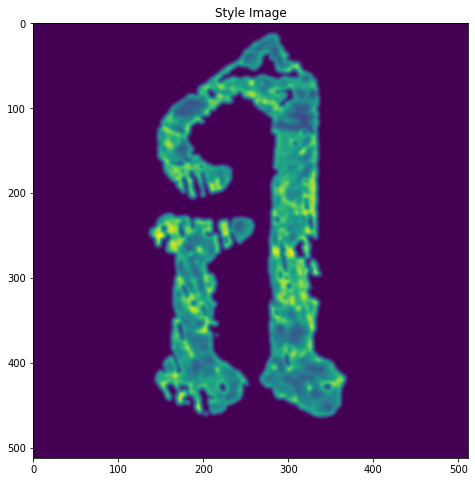

In [8]:
unloader = transforms.ToPILImage()  # reconv/content/grams/ert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure(figsize=(8,8))
imshow(style_img, title='Style Image')

## Define gram matrix & loss

In [9]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
    #print("feature response current size:  ", input.size())

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    #print("features:  ", features.size())

    G = torch.mm(features, features.t())  # compute the gram product
    #print("G:  ", G.size())
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [10]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


##Importing the Model
Import the pretrained model and select only the convoluted part. Plot of model summary to check the convoluted layers 


In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [12]:
from torchsummary import summary
summary(cnn, ( 3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [26]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [27]:
#New model with losses added as transparent layers 
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img,style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses

In [29]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

unloader = transforms.ToPILImage()  # reconv/content/grams/ert into PIL image
plt.ion()

# automated matrices

In [16]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       style_img, input_img, num_steps=1,
                       style_weight=1000000, content_weight=1,name="gram"):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)
    
    i = 0
    for sl in style_losses:
        matrix = sl.target.cpu().numpy()
        print("saved gram" + str(i))
        np.save("/home/fmerizzi/Documents/letter_style/new_letters/"+ true + "_gram/gram" + str(i), matrix)
        i +=1
        


    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [31]:
for i in range(8):
    #select the image 
    folder = "/home/fmerizzi/Documents/letter_style/new_letters/4/bw_512_blur/"
    true = "blur_re_bw_i"+str(i+1)
    name = true+".png"
    style_source = folder+name
    style_img = image_loader(style_source)
    unloader = transforms.ToPILImage()  # reconv/content/grams/ert into PIL image
    plt.ion()

    input_img = torch.randn(style_img.data.size(), device=device)

    # add the original input image to the figure:
    #plt.figure()
    #imshow(input_img, title='Input Image')
    import numpy as np
    import os
    try:
      os.mkdir("/home/fmerizzi/Documents/letter_style/new_letters/"+true+"_gram")
    except:
      print("already_exists")
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, style_img, input_img,name)

    plt.figure()
    #imshow(output, title='Output Image')

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

already_exists
Building the style transfer model..


/tmp/ipykernel_13583/1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_13583/1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


saved gram0
saved gram1
saved gram2
saved gram3
saved gram4
saved gram5
saved gram6
saved gram7
saved gram8
saved gram9
saved gram10
saved gram11
saved gram12
saved gram13
saved gram14
saved gram15


<Figure size 432x288 with 0 Axes>

already_exists
Building the style transfer model..
saved gram0
saved gram1
saved gram2
saved gram3
saved gram4
saved gram5
saved gram6
saved gram7
saved gram8
saved gram9
saved gram10
saved gram11
saved gram12
saved gram13
saved gram14
saved gram15


<Figure size 432x288 with 0 Axes>

already_exists
Building the style transfer model..
saved gram0
saved gram1
saved gram2
saved gram3
saved gram4
saved gram5
saved gram6
saved gram7
saved gram8
saved gram9
saved gram10
saved gram11
saved gram12
saved gram13
saved gram14
saved gram15


<Figure size 432x288 with 0 Axes>

already_exists
Building the style transfer model..
saved gram0
saved gram1
saved gram2
saved gram3
saved gram4
saved gram5
saved gram6
saved gram7
saved gram8
saved gram9
saved gram10
saved gram11
saved gram12
saved gram13
saved gram14
saved gram15


<Figure size 432x288 with 0 Axes>

already_exists
Building the style transfer model..
saved gram0
saved gram1
saved gram2
saved gram3
saved gram4
saved gram5
saved gram6
saved gram7
saved gram8
saved gram9
saved gram10
saved gram11
saved gram12
saved gram13
saved gram14
saved gram15


<Figure size 432x288 with 0 Axes>

already_exists
Building the style transfer model..
saved gram0
saved gram1
saved gram2
saved gram3
saved gram4
saved gram5
saved gram6
saved gram7
saved gram8
saved gram9
saved gram10
saved gram11
saved gram12
saved gram13
saved gram14
saved gram15


<Figure size 432x288 with 0 Axes>

already_exists
Building the style transfer model..
saved gram0
saved gram1
saved gram2
saved gram3
saved gram4
saved gram5
saved gram6
saved gram7
saved gram8
saved gram9
saved gram10
saved gram11
saved gram12
saved gram13
saved gram14
saved gram15


<Figure size 432x288 with 0 Axes>

already_exists
Building the style transfer model..
saved gram0
saved gram1
saved gram2
saved gram3
saved gram4
saved gram5
saved gram6
saved gram7
saved gram8
saved gram9
saved gram10
saved gram11
saved gram12
saved gram13
saved gram14
saved gram15


<Figure size 432x288 with 0 Axes>

## Displaying the obtained matrices 
The gram matrices have all been saved in .npy format. 

In [99]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [162]:
#select .npy files folder 
folder_path = '/home/fmerizzi/Documents/letter_style/new_letters/grams/blur_re_bw_v2_gram'

In [163]:
grams = []
for i in range(len(style_layers_default)):
  tmp = np.load(folder_path + "/gram" + str(i) + ".npy")
  # uncomment for scaling
  #tmp = scaler.fit_transform(np.load(folder_path + "/gram" + str(i) + ".npy"))
  grams.append(tmp)

### display single matrices 

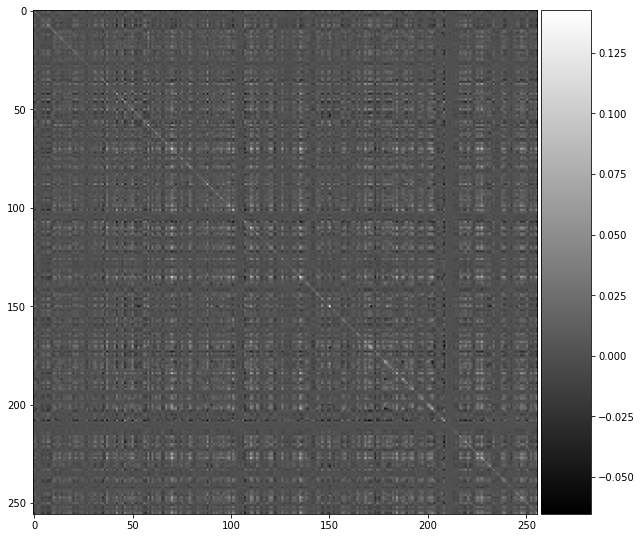

In [150]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(10,10))
ax = plt.subplot()
im = ax.imshow(grams[4],cmap="gray")
#ax.set_xticks(range(200,250,1))
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()

### display multiple matrices

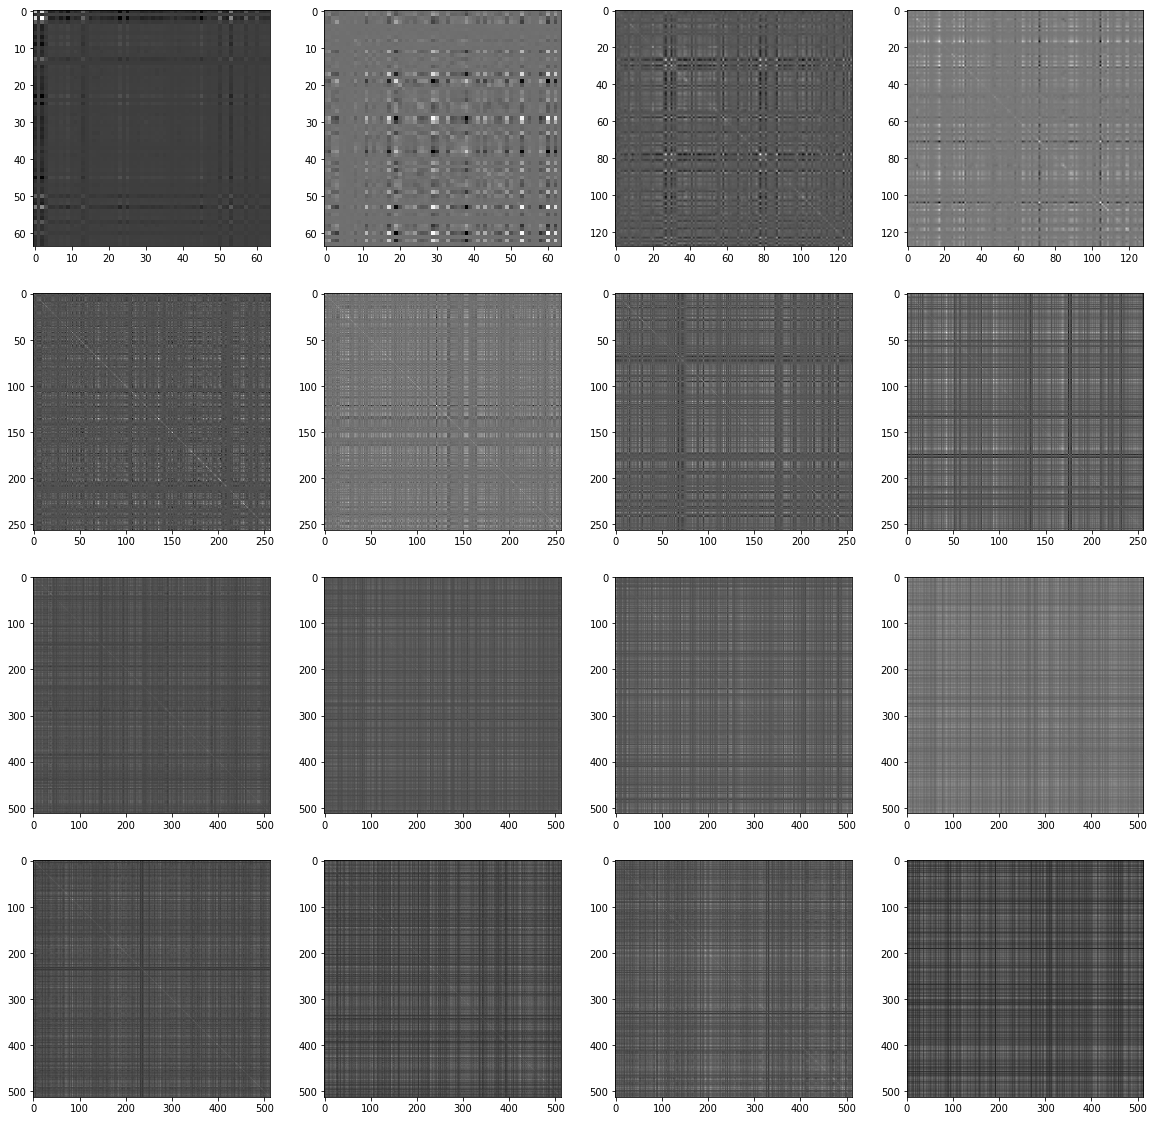

In [161]:

f, axarr = plt.subplots(4,4, figsize=(20,20))
for i in range(0,4):
  test = 2
  for j in range(0,4):
    test = axarr[i,j].imshow(grams[(4*i) + j],cmap="gray")

### produce a list of all the involved matrices with indexes 

In [33]:
names = []

In [34]:
for i in range(8):
    #select the image 
    #folder = "/home/fmerizzi/Documents/letter_style/new_letters/4/bw_512_blur/"
    true = "blur_re_bw_v"+str(i+1)
    test = "/home/fmerizzi/Documents/letter_style/new_letters/"+true+"_gram"
    print(test)
    names.append(true+"_gram")

for i in range(11):
    #select the image 
    #folder = "/home/fmerizzi/Documents/letter_style/new_letters/4/bw_512_blur/"
    true = "blur_re_bw_s"+str(i+1)
    test = "/home/fmerizzi/Documents/letter_style/new_letters/"+true+"_gram"
    print(test)
    names.append(true+"_gram")
    
for i in range(8):
    #select the image 
    #folder = "/home/fmerizzi/Documents/letter_style/new_letters/4/bw_512_blur/"
    true = "blur_re_bw_l"+str(i+1)
    test = "/home/fmerizzi/Documents/letter_style/new_letters/"+true+"_gram"
    print(test)
    names.append(true+"_gram")
    
for i in range(8):
    #select the image 
    #folder = "/home/fmerizzi/Documents/letter_style/new_letters/4/bw_512_blur/"
    true = "blur_re_bw_i"+str(i+1)
    test = "/home/fmerizzi/Documents/letter_style/new_letters/"+true+"_gram"
    print(test)
    names.append(true+"_gram")

/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_v1_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_v2_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_v3_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_v4_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_v5_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_v6_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_v7_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_v8_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_s1_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_s2_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_s3_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_s4_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_s5_gram
/home/fmerizzi/Documents/letter_style/new_letters/blur_re_bw_s6_gram
/home/fmerizzi/Documents/letter_st

### Check cge names are corrects 

In [35]:
names

['blur_re_bw_v1_gram',
 'blur_re_bw_v2_gram',
 'blur_re_bw_v3_gram',
 'blur_re_bw_v4_gram',
 'blur_re_bw_v5_gram',
 'blur_re_bw_v6_gram',
 'blur_re_bw_v7_gram',
 'blur_re_bw_v8_gram',
 'blur_re_bw_s1_gram',
 'blur_re_bw_s2_gram',
 'blur_re_bw_s3_gram',
 'blur_re_bw_s4_gram',
 'blur_re_bw_s5_gram',
 'blur_re_bw_s6_gram',
 'blur_re_bw_s7_gram',
 'blur_re_bw_s8_gram',
 'blur_re_bw_s9_gram',
 'blur_re_bw_s10_gram',
 'blur_re_bw_s11_gram',
 'blur_re_bw_l1_gram',
 'blur_re_bw_l2_gram',
 'blur_re_bw_l3_gram',
 'blur_re_bw_l4_gram',
 'blur_re_bw_l5_gram',
 'blur_re_bw_l6_gram',
 'blur_re_bw_l7_gram',
 'blur_re_bw_l8_gram',
 'blur_re_bw_i1_gram',
 'blur_re_bw_i2_gram',
 'blur_re_bw_i3_gram',
 'blur_re_bw_i4_gram',
 'blur_re_bw_i5_gram',
 'blur_re_bw_i6_gram',
 'blur_re_bw_i7_gram',
 'blur_re_bw_i8_gram']

## Calculate all the dissimilarities scores 

In [36]:
ones = names
twos = names
dissimilarities = []

In [37]:
for one in ones: 
    for two in twos: 
        #select the two paths of gram matrices 
        folder_path1 = '/home/fmerizzi/Documents/letter_style/new_letters/' + one
        folder_path2 = "/home/fmerizzi/Documents/letter_style/new_letters/" + two 
        first = "/home/fmerizzi/Documents/letter_style/" + one +".png"
        second = "/home/fmerizzi/Documents/letter_style/" + two +".png"
        
        grams1 = []
        for i in range(len(style_layers_default)):
          tmp = np.load(folder_path1 + "/gram" + str(i) + ".npy")
          # uncomment for scaling
          #tmp = scaler.fit_transform(np.load(folder_path + "/gram" + str(i) + ".npy"))
          grams1.append(tmp)
        grams2 = []
        for i in range(len(style_layers_default)):
          tmp = np.load(folder_path2 + "/gram" + str(i) + ".npy")
          # uncomment for scaling
          #tmp = scaler.fit_transform(np.load(folder_path + "/gram" + str(i) + ".npy"))
          grams2.append(tmp)
            
        norms = []
        for i in range(0,4):
            for j in range(0,4):
                diff_matrix = grams1[(4*i) + j] - grams2[(4*i) + j]
                norm = np.linalg.norm(diff_matrix) / diff_matrix.shape[1]
                norms.append(norm)
        #style similarity score 
        style_similarity_score = np.mean(np.array(norms))
        dissimilarities.append(np.around(style_similarity_score,4) * 100)
        #print("style similarity mean score = " + str(np.around(style_similarity_score,4)))
        #name1 = folder_path1.split("/")[-1]        
        #name2 = folder_path2.split("/")[-1]        
        #f, axarr = plt.subplots(1,2, figsize=(10,5))
        #axarr[0].imshow(plt.imread(first))
        #axarr[0].set_title("mean dissimilarity score -> " + str(np.around(style_similarity_score,4)))
        #axarr[1].imshow(plt.imread(second))
        #axarr[1].set_title(name1 + " - " + name2)
        #f.savefig("/home/fmerizzi/Documents/letter_style/results/" + name1 + "-" + name2 + ".png")
        
        
        

In [38]:
#check the correct numebr of results 
len(dissimilarities)

1225

### now lets plot the results, we need a reshape and we use pandas to produce a nice plot 

In [40]:
table = np.reshape(np.array(dissimilarities), (35,35))

In [41]:
# I DID NOT WRITE THIS BY HAND, I DID SOME REGEX ON THE NAMES 
import pandas as pd
pand = pd.DataFrame(table,['v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 'l1',
 'l2',
 'l3',
 'l4',
 'l5',
 'l6',
 'l7',
 'l8',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8'],['v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 'l1',
 'l2',
 'l3',
 'l4',
 'l5',
 'l6',
 'l7',
 'l8',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8'])

In [42]:
#and our final table!
display(pand)

,v1,v2,v3,v4,v5,v6,v7,v8,s1,s2,...,l7,l8,i1,i2,i3,i4,i5,i6,i7,i8
v1,0.00,0.29,0.27,0.74,0.32,0.56,0.36,0.41,0.45,0.70,...,0.46,1.65,0.47,0.49,0.61,0.39,0.58,0.60,0.52,0.60
v2,0.29,0.00,0.21,0.65,0.30,0.49,0.27,0.38,0.45,0.72,...,0.59,1.79,0.47,0.46,0.57,0.45,0.55,0.61,0.47,0.59
v3,0.27,0.21,0.00,0.58,0.23,0.44,0.35,0.46,0.51,0.67,...,0.58,1.80,0.36,0.51,0.49,0.38,0.49,0.59,0.43,0.52
v4,0.74,0.65,0.58,0.00,0.57,0.45,0.71,0.83,0.91,0.66,...,0.98,2.19,0.51,0.81,0.47,0.67,0.61,0.79,0.64,0.65
v5,0.32,0.30,0.23,0.57,0.00,0.46,0.38,0.48,0.52,0.62,...,0.59,1.78,0.33,0.51,0.48,0.36,0.49,0.55,0.45,0.51
v6,0.56,0.49,0.44,0.45,0.46,0.00,0.41,0.62,0.69,0.65,...,0.83,2.00,0.51,0.66,0.59,0.61,0.64,0.74,0.64,0.68
v7,0.36,0.27,0.35,0.71,0.38,0.41,0.00,0.32,0.41,0.71,...,0.61,1.74,0.53,0.42,0.65,0.49,0.61,0.60,0.54,0.64
v8,0.41,0.38,0.46,0.83,0.48,0.62,0.32,0.00,0.38,0.75,...,0.53,1.63,0.62,0.27,0.65,0.49,0.56,0.49,0.49,0.59
s1,0.45,0.45,0.51,0.91,0.52,0.69,0.41,0.38,0.00,0.66,...,0.47,1.56,0.65,0.39,0.72,0.56,0.66,0.58,0.59,0.65
s2,0.70,0.72,0.67,0.66,0.62,0.65,0.71,0.75,0.66,0.00,...,0.73,1.85,0.58,0.70,0.58,0.62,0.63,0.69,0.68,0.62


In [46]:
# I drop these specific columns because they are clearly outliers (different color background)
pand = pand.drop(['l2', 'l4','l6','l8'], axis=0)

In [47]:
#Finally save the png 
import pandas as pd
import numpy as np
import dataframe_image as dfi
#df = pd.DataFrame(np.random.randn(6, 6), columns=list('ABCDEF'))
df_styled = pand.style.background_gradient(axis=None)
dfi.export(df_styled,"/home/fmerizzi/Desktop/results.png",max_cols=-1)

[0112/160806.272134:ERROR:gpu_init.cc(523)] Passthrough is not supported, GL is disabled, ANGLE is 
[0112/160806.272471:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0112/160806.523745:INFO:headless_shell.cc(623)] Written to file /tmp/tmpzbtagq3e/temp.png.
[0112/160806.674739:ERROR:gpu_init.cc(523)] Passthrough is not supported, GL is disabled, ANGLE is 
[0112/160806.674927:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0112/160807.016910:INFO:headless_shell.cc(623)] Written to file /tmp/tmp08a1_9jr/temp.png.
[0112/160807.229138:ERROR:gpu_init.cc(523)] Passthrough is not supported, GL is disabled, ANGLE is 
[0112/160807.229461:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0112/160807.624937:INFO:headless_shell.cc(623)] Written to file /tmp/tmprhzjkdk6/temp.png.
